# Point cloud classification with Pointnet using Keras


## Introduction

Classification of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593) for a synthetic dataset. 


## Setup

In [1]:
# !pip install tensorflow
# !pip install seaborn
import tensorflow as tf
print(tf.__version__)

2023-11-20 02:24:40.949232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 02:24:42.284480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras import callbacks

from DataSetsLoader import DataSetsLoader
from OrthogonalRegularizer import OrthogonalRegularizer

tf.random.set_seed(123)


## Load dataset

We use the Dublin synthetic dataset, there are 3 major classes taken in consideration namely building, trees and roads/ground.


Set the number of points to sample and batch size and parse the dataset.

In [3]:
NUM_POINTS = 4096
NUM_CLASSES = 3
BATCH_SIZE = 32

In [4]:
# Load Datasets
datasets_loader = DataSetsLoader(NUM_POINTS,NUM_CLASSES)
train_points, test_points, val_points, train_labels, test_labels, val_labels = datasets_loader.transform_to_tensorflow_dataset()

In [5]:
print(train_labels)
print(val_labels)
print(test_labels)

['b' 'g' 'b' 'b' 'b' 'g' 'b' 'g' 'b' 'V' 'V' 'b' 'b' 'V' 'b' 'g' 'b' 'V'
 'g' 'g' 'g' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'b' 'g' 'V' 'g' 'g' 'b' 'b' 'b'
 'g' 'g' 'b' 'g' 'b' 'g' 'g' 'b' 'g' 'b' 'g' 'V' 'b' 'g' 'g' 'b' 'b' 'b'
 'g' 'g' 'V' 'g' 'g' 'b' 'g' 'V' 'b' 'g' 'g' 'g']
['V' 'b' 'b' 'g' 'b' 'b' 'g' 'V' 'b' 'g' 'b' 'g' 'g' 'g' 'b' 'g' 'b' 'b'
 'g' 'V' 'b' 'g' 'b']
['g' 'g' 'V' 'V' 'b' 'g' 'b' 'g' 'b' 'g' 'g' 'b' 'g' 'g' 'g' 'g' 'b' 'V'
 'b' 'b' 'b' 'b' 'b' 'b']


In [6]:
#Check for any Nans
import math
np.argwhere(np.isnan(train_points))

array([], shape=(0, 3), dtype=int64)

In [7]:
def label_mapping(lbl):
    if(lbl.lower() == 'b'):
        return 0
    if(lbl.lower() == 'g'):
        return 1
    if(lbl.lower() == 'v'):
        return 2
    else:
        return None

In [8]:
train_label=[]
test_label=[]
val_label=[]
for i in train_labels:
    label_train = label_mapping(i.lower())
    if(label_train!=None):
#         train_label.append(int(label_train))
        train_label.append(label_train)
        
for j in test_labels:  
    label_tst = label_mapping(j.lower())
    if(label_tst!=None):
        test_label.append(label_tst)

for k in val_labels:  
    label_val = label_mapping(k.lower())
    if(label_val!=None):
        val_label.append(label_val)
        
# train_label = tf.one_hot(train_label, depth=3)       
# test_label = tf.one_hot(test_label, depth=3)

print(train_label)    
print(test_label)
print(val_label)    

[0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 0, 1, 1, 1]
[1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 0]


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [9]:

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_points, val_label))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# val_dataset = val_dataset.shuffle(len(val_points)).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = train_dataset.map(augment).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-11-20 02:24:49.472973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).

In [10]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)



In [11]:
# class OrthogonalRegularizer(keras.regularizers.Regularizer):
#     def __init__(self, num_features, l2reg=0.001):        
#         self.num_features = num_features
#         self.l2reg = l2reg
#         self.eye = tf.eye(num_features)        

#     # gets called at each train iteration
#     def __call__(self, x): # your custom function here
#         x = tf.reshape(x, (-1, self.num_features, self.num_features))
#         xxt = tf.tensordot(x, x, axes=(2, 2))
#         xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
#         return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

#     def get_config(self): # required class method
#         return {"num_features": self.num_features,
#                 "l2reg": self.l2reg}
    
# cl_test = OrthogonalRegularizer(3) 
# config_test_cl = cl_test.get_config() 
# print(config_test_cl) 
# cl_test_ = OrthogonalRegularizer.from_config(config_test_cl)


### tnet layer function

 We can then define a general function to build T-net layers, similar to fig: 
 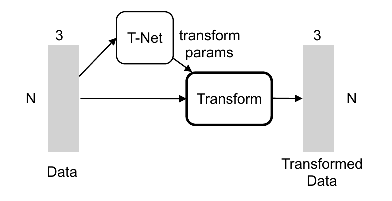

---




In [12]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



### Variale learning rate

The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [13]:
initial_learning_rate = 0.001    
decay_steps = 7000  #200000
decay_rate = 0.7
# MOMENTUM = 0.99
def get_learning_rate(initial_learning_rate,decay_steps, decay_rate):
    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None)
    return learning_rate 

### Create model


In [14]:
def create_model():
    inputs = keras.Input(shape=(NUM_POINTS, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

model = create_model()
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(get_learning_rate(initial_learning_rate,decay_steps, decay_rate)),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 4096, 32)             0         ['batch_normalization[0

### Train model

In [15]:
checkpoint_path = 'my_realtime_model_save'
es = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience = 3)
mc = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_sparse_categorical_accuracy', mode='max', verbose=1)

history = model.fit(train_dataset, epochs=80, validation_data=val_dataset, callbacks = [es,mc])

Epoch 1/80
3/3 [==============================] - ETA: 0s - loss: 3.2963 - sparse_categorical_accuracy: 0.4545
Epoch 1: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 35s 10s/step - loss: 3.2963 - sparse_categorical_accuracy: 0.4545 - val_loss: 2.6942 - val_sparse_categorical_accuracy: 0.3913
Epoch 2/80
3/3 [==============================] - ETA: 0s - loss: 2.9159 - sparse_categorical_accuracy: 0.7576
Epoch 2: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 20s 8s/step - loss: 2.9159 - sparse_categorical_accuracy: 0.7576 - val_loss: 2.7000 - val_sparse_categorical_accuracy: 0.4348
Epoch 3/80
3/3 [==============================] - ETA: 0s - loss: 2.8583 - sparse_categorical_accuracy: 0.8333
Epoch 3: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 20s 8s/step - loss: 2.8583 - sparse_categorical_accuracy: 0.8333 - val_loss: 2.5725 - val_sparse_categorical_accuracy: 0.4348
Epoch 4/80
3/3 [==============================] - ETA: 0s - loss: 2.9293 - sparse_categorical_accuracy: 0.7879
Epoch 4: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 19s 8s/step - loss: 2.9293 - sparse_categorical_accuracy: 0.7879 - val_loss: 2.4243 - val_sparse_categorical_accuracy: 0.7826
Epoch 5/80
3/3 [==============================] - ETA: 0s - loss: 3.0122 - sparse_categorical_accuracy: 0.7424
Epoch 5: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 21s 9s/step - loss: 3.0122 - sparse_categorical_accuracy: 0.7424 - val_loss: 2.3567 - val_sparse_categorical_accuracy: 0.6957
Epoch 6/80
3/3 [==============================] - ETA: 0s - loss: 3.0284 - sparse_categorical_accuracy: 0.7879
Epoch 6: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 22s 9s/step - loss: 3.0284 - sparse_categorical_accuracy: 0.7879 - val_loss: 2.3470 - val_sparse_categorical_accuracy: 0.6957
Epoch 7/80
3/3 [==============================] - ETA: 0s - loss: 3.2417 - sparse_categorical_accuracy: 0.8030
Epoch 7: saving model to my_realtime_model_save
INFO:tensorflow:Assets written to: my_realtime_model_save/assets


INFO:tensorflow:Assets written to: my_realtime_model_save/assets


3/3 [==============================] - 22s 9s/step - loss: 3.2417 - sparse_categorical_accuracy: 0.8030 - val_loss: 2.3844 - val_sparse_categorical_accuracy: 0.6087
Epoch 7: early stopping


## Training Loss Graph

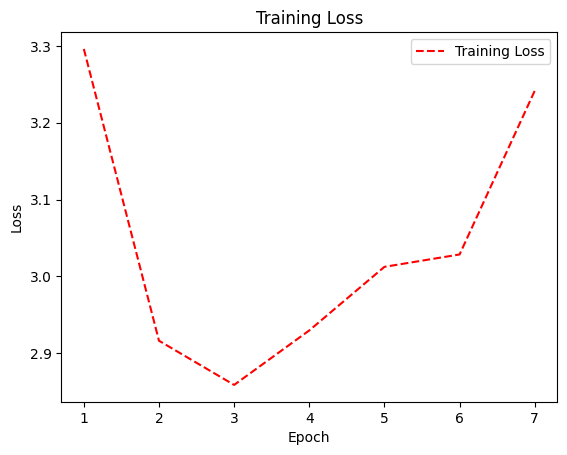

In [16]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, val_loss, 'b-')
plt.title('Training Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Validation Loss Graph

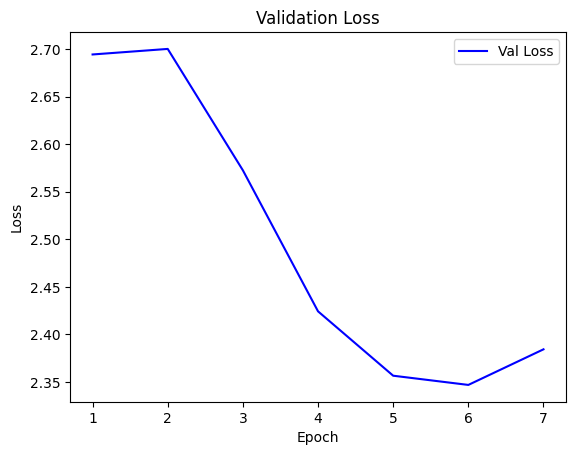

In [17]:
epoch_count = range(1, len(training_loss)+1)

plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Val Loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Model Accuracy Graph

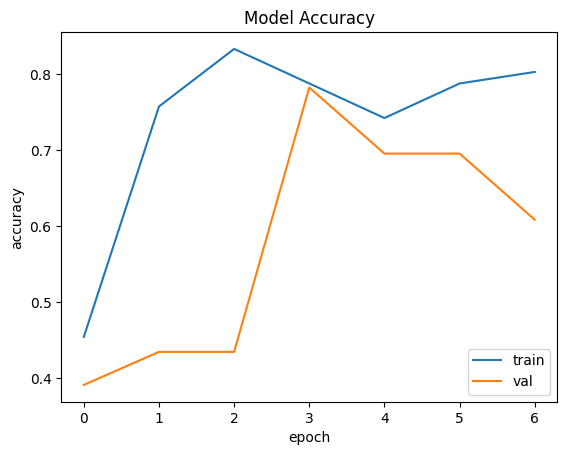

In [18]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Model output after 107 epochs

The model was run for 150 epochs, because of early stopping, the model training was stopped at 107 epochs. But the accuracy achieved on both training and validation was less than values in prior epochs. So the model was saved when the validation accuracy was at its peak.
The results below are early stopping results:

## Visualize predictions

1/1 [==============================] - 1s 1s/step


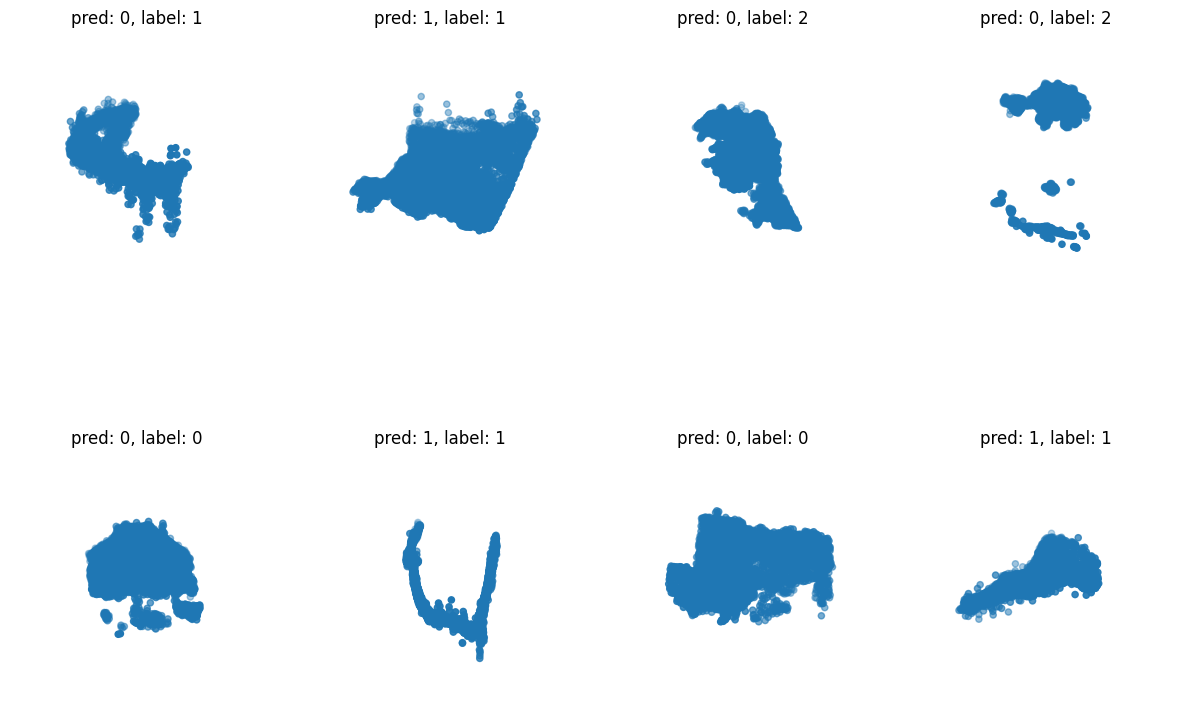

In [19]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


In [20]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 1s 528ms/step
Accuracy  is 0.0
1/1 [==============================] - 1s 594ms/step
Accuracy  is 0.5
1/1 [==============================] - 1s 549ms/step
Accuracy  is 0.3333333333333333
1/1 [==============================] - 0s 485ms/step
Accuracy  is 0.25
1/1 [==============================] - 1s 531ms/step
Accuracy  is 0.4
1/1 [==============================] - 1s 555ms/step
Accuracy  is 0.5
1/1 [==============================] - 0s 487ms/step
Accuracy  is 0.5714285714285714
1/1 [==============================] - 1s 505ms/step
Accuracy  is 0.625
1/1 [==============================] - 1s 569ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 0s 469ms/step
Accuracy  is 0.6
1/1 [==============================] - 1s 506ms/step
Accuracy  is 0.5454545454545454
1/1 [==============================] - 1s 533ms/step
Accuracy  is 0.5833333333333334
1/1 [==============================] - 1s 574ms/step
Accuracy  is 0.61538461538461

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [22]:
label_names = np.array(['building','ground','vegetation'])

## Confusion Matrix

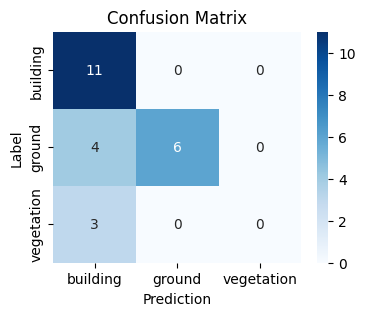

Accuracy: 0.708333
Precision: 0.708333
Recall: 0.708333
F1 score: 0.708333
              precision    recall  f1-score   support

    building       0.61      1.00      0.76        11
      ground       1.00      0.60      0.75        10
  vegetation       0.00      0.00      0.00         3

    accuracy                           0.71        24
   macro avg       0.54      0.53      0.50        24
weighted avg       0.70      0.71      0.66        24



/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))


# Saved model output

The results below are best model saved results:

In [24]:
saved_model = create_model()
saved_model.load_weights(checkpoint_path)

2023-11-20 02:38:16.781960: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open my_realtime_model_save: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


1/1 [==============================] - 1s 1s/step


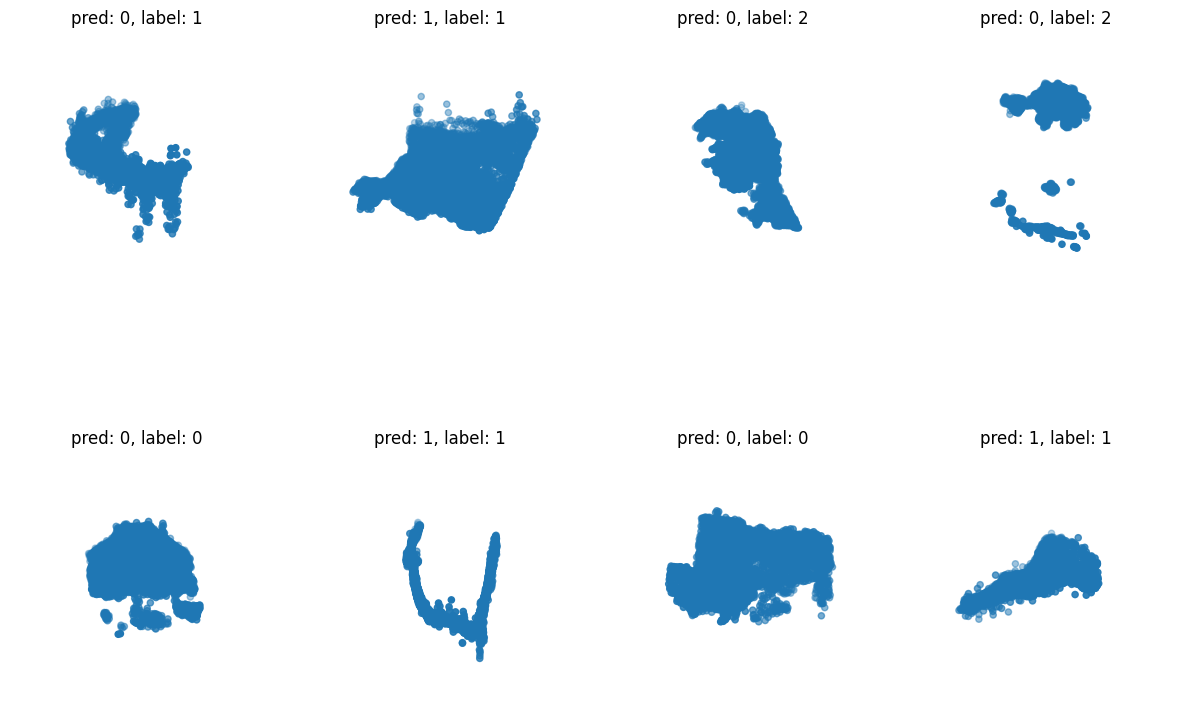

In [25]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = saved_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()


# Test dataset predictions

In [26]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = saved_model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = saved_model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 1s 519ms/step
Accuracy  is 0.0
1/1 [==============================] - 1s 581ms/step
Accuracy  is 0.5
1/1 [==============================] - 1s 657ms/step
Accuracy  is 0.3333333333333333
1/1 [==============================] - 1s 538ms/step
Accuracy  is 0.25
1/1 [==============================] - 1s 557ms/step
Accuracy  is 0.4
1/1 [==============================] - 1s 553ms/step
Accuracy  is 0.5
1/1 [==============================] - 0s 449ms/step
Accuracy  is 0.5714285714285714
1/1 [==============================] - 1s 572ms/step
Accuracy  is 0.625
1/1 [==============================] - 1s 585ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 1s 527ms/step
Accuracy  is 0.6
1/1 [==============================] - 1s 521ms/step
Accuracy  is 0.5454545454545454
1/1 [==============================] - 1s 627ms/step
Accuracy  is 0.5833333333333334
1/1 [==============================] - 1s 572ms/step
Accuracy  is 0.61538461538461

In [27]:
label_names = np.array(['building','ground','vegetation'])

## Confusion Matrix

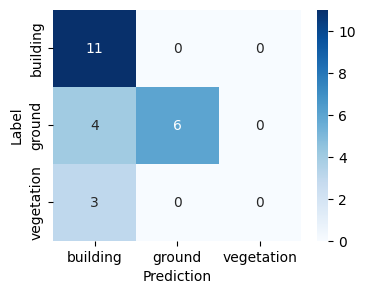

Accuracy: 0.708333
Precision: 0.708333
Recall: 0.708333
F1 score: 0.708333
              precision    recall  f1-score   support

    building       0.61      1.00      0.76        11
      ground       1.00      0.60      0.75        10
  vegetation       0.00      0.00      0.00         3

    accuracy                           0.71        24
   macro avg       0.54      0.53      0.50        24
weighted avg       0.70      0.71      0.66        24



/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))
